<a href="https://colab.research.google.com/github/dipayandas97/Spiking-Neural-Network/blob/master/STDP_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#Signal

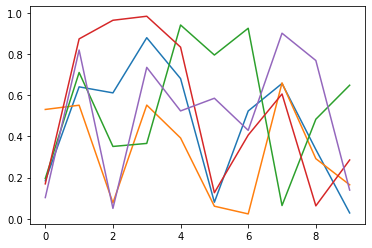

In [272]:
T = 10
input_dimension = 5
signal = np.random.rand(input_dimension,T)
for i in signal:
    plt.plot(i)

#Encoding

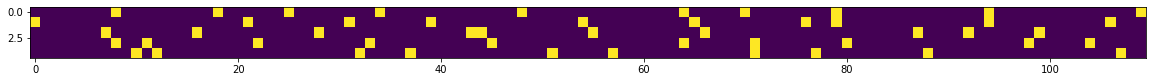

In [273]:
time_window = 10
spike_train = np.zeros((T, input_dimension, time_window+1))

for t in range(signal.shape[1]):
    s = signal[:,t]
    s = np.max(s) - s
    latency = time_window * ((s - np.min(s))/(np.max(s) - np.min(s)))

    for i in range(latency.shape[0]): #iterate over each dimension of data
        spike_train[t][i][int(latency[i])] = 1 

#Total encoded data

seq = spike_train[0]

for w in spike_train[1:]:
    seq = np.hstack((seq, w))

signal = seq

plt.figure(figsize=(20,4))
plt.imshow(seq)
plt.show()

#LIF neuron class

In [0]:
#@title Default title text
class Neuron(object):
    def __init__(self, threshold=1, dt=0.125):
        #simulation parameters
        self.dt = dt

        #LIF parameters
        self.Vres = 0                        #resting potential (V)
        self.Vm = self.Vres                  #current potential (V)
        self.t_rest = -1                     #initial resting time point
        self.tau_ref = 4                     #(ms) : refractory period
        self.Vth = threshold                 #(V)

        self.Rm = 1                          #kOhm
        self.Cm = 10                          #uF
        self.tau_m = self.Rm * self.Cm                 #(ms)
        self.V_spike = threshold+5                   #spike delta (V)
            
    def update(self, I, time_stamp):
        if time_stamp > self.t_rest:
            self.Vm = self.Vm + (((I*self.Rm - self.Vm) / self.tau_m) * self.dt)
            
            if self.Vm >= self.Vth:
                self.Vm = self.V_spike
                self.t_rest = time_stamp + self.tau_ref
        else:
            self.Vm = self.Vres
        return self.Vm
    
    def initialize(self):
        self.Vm = self.Vres
        self.t_rest = -1

#STDP functions

In [0]:
A_plus, A_minus, tau_plus, tau_minus = 0.5, 0.5, 5, 5
scale = 1
sigma = 0.1
w_max = 2*scale
w_min = -2*scale

def get_del_w(t): #del_t = t_pre - t_post

	if t>0:
		return -A_minus*np.exp(-float(t)/tau_minus)
	if t<=0:
		return A_plus*np.exp(float(t)/tau_plus)

def update_w(w, del_t): 

    del_w = get_del_w(del_t)

    if del_w < 0:
        e = abs(w_min)-w if w<0 else abs(w_min)+w #difference 
        return w + sigma*del_w*e*scale

    elif del_w > 0:
        return w + sigma*del_w*(w_max-w)*scale

#Network

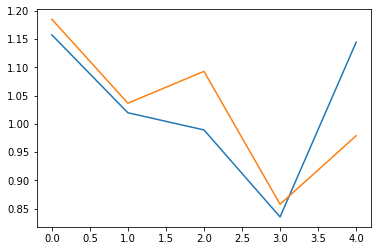

In [319]:
#Network parameters
m, n = input_dimension, 2

h_layer = []
for i in range(n):
    h_layer.append(Neuron(threshold=0.5, dt=1))

synapse = np.random.normal(loc=1,scale=0.2,size=(n,m))

#Before simulation
for i in range(n):
    plt.plot(synapse[i,:])

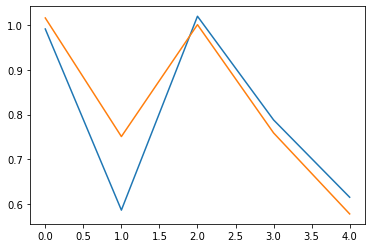

In [322]:
#After simulation
for i in range(n):
    plt.plot(synapse[i,:])

#Simulation

Epoch:  0


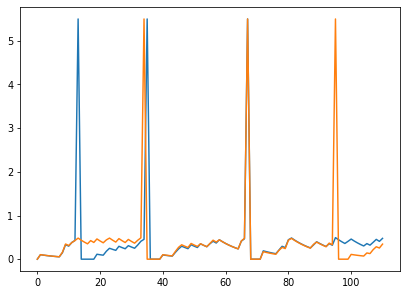

Epoch:  1


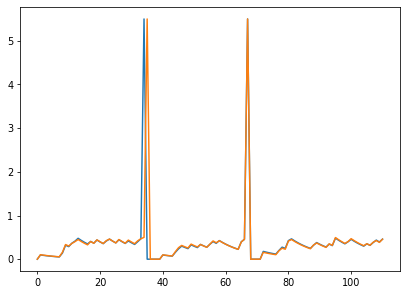

Epoch:  2


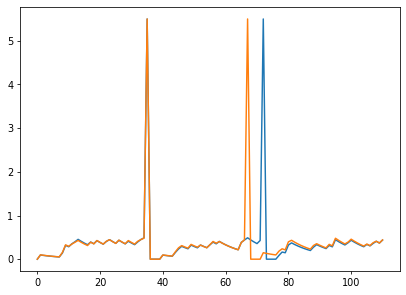

Epoch:  3


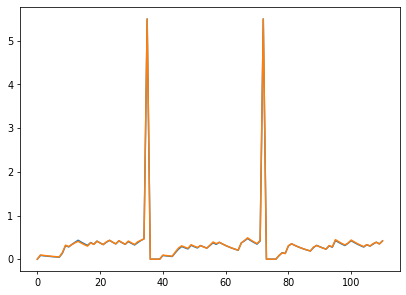

Epoch:  4


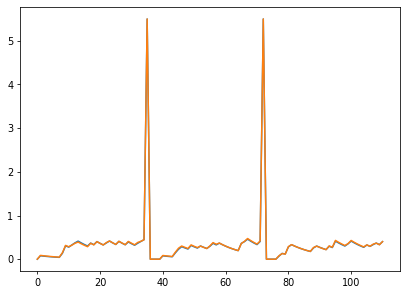

Epoch:  5


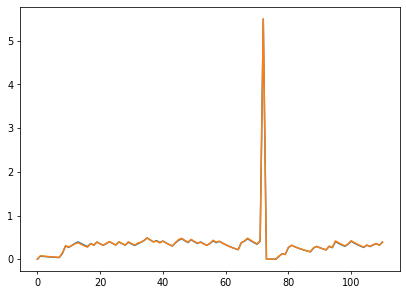

Epoch:  6


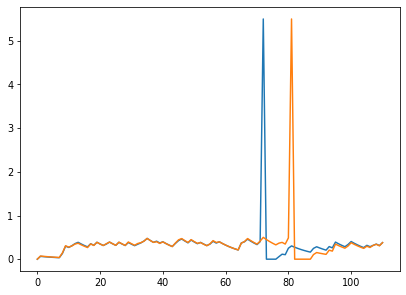

Epoch:  7


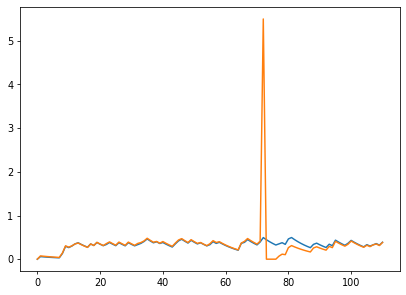

Epoch:  8


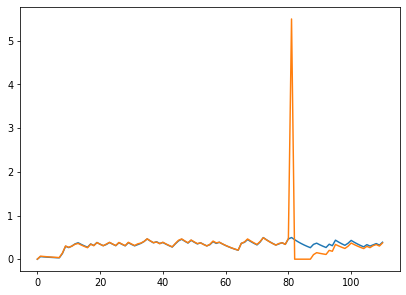

Epoch:  9


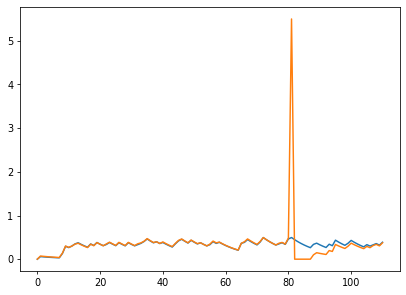

In [321]:
#simulation parameters
epochs = 10
T = signal.shape[1]
t_backward, t_forward = -10,10

for e in range(epochs):
    activations=[]
    for i in range(n):
        activations.append([0])

    for i in range(n):
        h_layer[i].initialize()

    for t in range(T):
        for idx,neuron in enumerate(h_layer):
            input_I = np.dot(synapse[idx],signal[:,t])
            activations[idx].append(neuron.update(input_I, t))

        for idx,neuron in enumerate(h_layer):
            if neuron.Vm == neuron.V_spike:
                for i in range(m):
                    for t1 in range(-2,t_backward,-1):
                        if 0<=t+t1<T:
                            if signal[i][t+t1] == 1:
                                synapse[idx][i] = update_w(synapse[idx][i], t1)

                    for t1 in range(2,t_forward,1):
                        if 0<=t+t1<T:
                            if signal[i][t+t1] == 1:
                                synapse[idx][i] = update_w(synapse[idx][i], t1)


    print('Epoch: ',e)                            
    plt.figure(figsize=(7,5), dpi=70)
    for i in range(n):
        plt.plot(activations[i])
    plt.show()